# Decision Tree & Random Forest model by spark

Spark is a computing engine designed for massively parallel Data Science. With pyspark, we can use spark in jupyter notebook. Spark provides a data frame-based machine learning library "ml". In this section, we tried decision tree and random forest model to predict the classification of network traffic (benign or attack). 

This section is divided into the following parts:

#### 1. EDA
#### 2. data processing
#### 3. pipeline
#### 4. Decision tree model
#### 5. Parameter tuning
#### 6. Compare with DT&RF in sklearn 

In [1]:
import pandas as pd
import pyspark
import findspark
import time
import pickle
import matplotlib as mpl
import matplotlib.pyplot as plt
from pyspark import SparkContext
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from pyspark.sql import SparkSession
from pyspark.ml import Pipeline
from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler
from pyspark.ml.classification import DecisionTreeClassifier
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.tuning import ParamGridBuilder, TrainValidationSplit, CrossValidator

First we check whether spark is installed and running normally.

In [2]:
findspark.init()
findspark.find()

'C:\\spark\\spark-3.1.1-bin-hadoop2.7'

## 1. EDA

The exploratory data analysis in pyspark is slightly different from regular pandas. In this section, we have made some attempts. First read the data and observe the data type, we found that there are 78 numerical features and 1 label. 

In [3]:
spark = SparkSession.builder.appName('ml-attack').getOrCreate()
df = spark.read.csv("Friday-WorkingHours-Afternoon-PortScan.pcap_ISCX.csv", header = True, inferSchema = True)
df.printSchema()

root
 |--  Destination Port: integer (nullable = true)
 |--  Flow Duration: integer (nullable = true)
 |--  Total Fwd Packets: integer (nullable = true)
 |--  Total Backward Packets: integer (nullable = true)
 |-- Total Length of Fwd Packets: integer (nullable = true)
 |--  Total Length of Bwd Packets: integer (nullable = true)
 |--  Fwd Packet Length Max: integer (nullable = true)
 |--  Fwd Packet Length Min: integer (nullable = true)
 |--  Fwd Packet Length Mean: double (nullable = true)
 |--  Fwd Packet Length Std: double (nullable = true)
 |-- Bwd Packet Length Max: integer (nullable = true)
 |--  Bwd Packet Length Min: integer (nullable = true)
 |--  Bwd Packet Length Mean: double (nullable = true)
 |--  Bwd Packet Length Std: double (nullable = true)
 |-- Flow Bytes/s: double (nullable = true)
 |--  Flow Packets/s: double (nullable = true)
 |--  Flow IAT Mean: double (nullable = true)
 |--  Flow IAT Std: double (nullable = true)
 |--  Flow IAT Max: integer (nullable = true)
 |-- 

Then we list data examples and statistical characteristics。

In [4]:
pd.set_option('display.max_rows', 79)
pd.DataFrame(df.take(5), columns=df.columns).transpose()

,0,1,2,3,4
Destination Port,22,22,22,22,35396
Flow Duration,1266342,1319353,160,1303488,77
Total Fwd Packets,41,41,1,41,1
Total Backward Packets,44,44,1,42,2
Total Length of Fwd Packets,2664,2664,0,2728,0
Total Length of Bwd Packets,6954,6954,0,6634,0
Fwd Packet Length Max,456,456,0,456,0
Fwd Packet Length Min,0,0,0,0,0
Fwd Packet Length Mean,64.9756,64.9756,0,66.5366,0
Fwd Packet Length Std,109.865,109.865,0,110.13,0


In [5]:
numeric_features = [t[0] for t in df.dtypes if t[1] == 'int']
df.select(numeric_features).describe().toPandas().transpose()

,0,1,2,3,4
summary,count,mean,stddev,min,max
Destination Port,286096,8015.814957217158,15346.254906099812,0,65389
Flow Duration,286096,5386306.348641715,2.1936997865904436E7,-13,119999949
Total Fwd Packets,286096,3.4763051563111684,19.527595617211297,1,3119
Total Backward Packets,286096,3.523953498126503,28.307086339347713,0,3635
Total Length of Fwd Packets,286096,233.70333035065153,1866.7146951985728,0,232349
Total Length of Bwd Packets,286096,2710.753970695151,51010.78140822222,0,7150819
Fwd Packet Length Max,286096,81.13227727755718,327.96891942409906,0,13929
Fwd Packet Length Min,286096,10.360361556959901,24.25221072183478,0,1472
Bwd Packet Length Max,286096,185.88710083328672,586.0631690985903,0,10136


## 2. data processing

Unlike pandas, Spark has its own set of data processing methods, including Category Indexing, One-Hot Encoding and VectorAssembler — a feature transformer that merges multiple columns into a vector column. In addition, spark can also do data normalization, but this is not a necessary prerequisite for decision trees and random forest models.  

In [6]:
stages = []
label_stringIdx = StringIndexer(inputCol=" Label", outputCol="label")
stages += [label_stringIdx]
asseblerInputs = df.columns[0: 78]
assembler = VectorAssembler(inputCols=asseblerInputs, outputCol="features")
stages += [assembler]

## 3. pipeline

We use Pipeline to chain multiple Transformers and Estimators together to specify our machine learning workflow. A Pipeline’s stages are specified as an ordered array.

In [7]:
cols = df.columns

pipeline = Pipeline(stages = stages)
pipelineModel = pipeline.fit(df)
df = pipelineModel.transform(df)

selectedCols = ['label', 'features'] + cols
df = df.select(selectedCols)
df.printSchema()

root
 |-- label: double (nullable = false)
 |-- features: vector (nullable = true)
 |--  Destination Port: integer (nullable = true)
 |--  Flow Duration: integer (nullable = true)
 |--  Total Fwd Packets: integer (nullable = true)
 |--  Total Backward Packets: integer (nullable = true)
 |-- Total Length of Fwd Packets: integer (nullable = true)
 |--  Total Length of Bwd Packets: integer (nullable = true)
 |--  Fwd Packet Length Max: integer (nullable = true)
 |--  Fwd Packet Length Min: integer (nullable = true)
 |--  Fwd Packet Length Mean: double (nullable = true)
 |--  Fwd Packet Length Std: double (nullable = true)
 |-- Bwd Packet Length Max: integer (nullable = true)
 |--  Bwd Packet Length Min: integer (nullable = true)
 |--  Bwd Packet Length Mean: double (nullable = true)
 |--  Bwd Packet Length Std: double (nullable = true)
 |-- Flow Bytes/s: double (nullable = true)
 |--  Flow Packets/s: double (nullable = true)
 |--  Flow IAT Mean: double (nullable = true)
 |--  Flow IAT Std

We can see that there are two more columns in the data, which are the index of the label and the vector composed of all the features. And we can check the status of the pipeline. 

In [8]:
pipeline.getStages()

[StringIndexer_540169ae4fc4, VectorAssembler_f5fa22d87b93]

In [9]:
pd.DataFrame(df.take(5), columns=df.columns).transpose()

,0,1,2,3,4
label,1,1,1,1,1
features,"(22.0, 1266342.0, 41.0, 44.0, 2664.0, 6954.0, ...","(22.0, 1319353.0, 41.0, 44.0, 2664.0, 6954.0, ...","(22.0, 160.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0....","(22.0, 1303488.0, 41.0, 42.0, 2728.0, 6634.0, ...","(35396.0, 77.0, 1.0, 2.0, 0.0, 0.0, 0.0, 0.0, ..."
Destination Port,22,22,22,22,35396
Flow Duration,1266342,1319353,160,1303488,77
Total Fwd Packets,41,41,1,41,1
...,...,...,...,...,...
Idle Mean,0,0,0,0,0
Idle Std,0,0,0,0,0
Idle Max,0,0,0,0,0
Idle Min,0,0,0,0,0


In order to use the ML model to predict the type of traffic (benign or attack), we divided the training set and the test set. 

In [10]:
train_df, test_df = df.randomSplit([0.7, 0.3], seed = 2021)
#train_df.cache()
#test_df.cache()
print("Training Dataset Count: " + str(train_df.count()))
print("Test Dataset Count: " + str(test_df.count()))

Training Dataset Count: 200442
Test Dataset Count: 85654


## 4. Decision tree mode

Decision tree is one of the most widely used machine learning classification algorithms. In spark, we bring the feature vector set and indexed labels obtained from the previous data processing into the model, train and test the model, and record the time spent. 

In [11]:
time_dt=[]

time_start=time.time()

from pyspark.ml.classification import DecisionTreeClassifier
dt = DecisionTreeClassifier(featuresCol = 'features', labelCol = 'label', maxDepth = 20)
dtModel = dt.fit(train_df)
predictions = dtModel.transform(test_df)

time_end=time.time()
time_dt.append(time_end-time_start)
print('totally cost',time_end-time_start)

totally cost 7.913947582244873


In [12]:
predictions.select('label', 'prediction', 'probability').show(10)

+-----+----------+--------------------+
|label|prediction|         probability|
+-----+----------+--------------------+
|  0.0|       0.0|           [1.0,0.0]|
|  0.0|       1.0|[0.00490196078431...|
|  0.0|       1.0|           [0.0,1.0]|
|  0.0|       1.0|           [0.0,1.0]|
|  1.0|       1.0|           [0.0,1.0]|
|  1.0|       1.0|           [0.0,1.0]|
|  1.0|       1.0|           [0.0,1.0]|
|  1.0|       1.0|           [0.0,1.0]|
|  1.0|       1.0|           [0.0,1.0]|
|  1.0|       1.0|           [0.0,1.0]|
+-----+----------+--------------------+
only showing top 10 rows



According to the model results, we calculate that the AUC value is very close to 1, which shows that the prediction effect of the decision tree in spark is very good. 

In [13]:
evaluator = BinaryClassificationEvaluator(rawPredictionCol="rawPrediction", labelCol="label", metricName="areaUnderROC")
auc = evaluator.evaluate(predictions)
auc

0.9999413046781148

## 5. Parameter tuning

In machine learning algorithms, parameter tuning is a very important task. We use grid search to find the most suitable parameters. We have prepared the corresponding training set and test set for testing.

In [14]:
df = spark.read.csv("Friday-WorkingHours-Afternoon-PortScan.pcap_ISCX.csv", header = True, inferSchema = True)
train, test = df.randomSplit([0.7, 0.3], seed = 2021)

In [15]:
paramGrid = ParamGridBuilder().addGrid(dt.impurity, ["gini", "entropy"]).addGrid(dt.maxDepth, [5,10,15,20,25]).addGrid(dt.maxBins, [10, 15, 20]).build()

tsv = TrainValidationSplit(estimator=dt, evaluator=evaluator, estimatorParamMaps=paramGrid, trainRatio=0.7)
tsv_pipeline = Pipeline(stages = [label_stringIdx, assembler, tsv]) # dt to tsv 
tsv_pipelineModel = tsv_pipeline.fit(train)
bestModel = tsv_pipelineModel.stages[2].bestModel # find the best model
tsv_prediction = tsv_pipelineModel.transform(test)
tsv_auc = evaluator.evaluate(tsv_prediction)
tsv_auc

0.9998913105859526

In this way, we get the parameters corresponding to the best model and its AUC value. 

In [16]:
bestModel

DecisionTreeClassificationModel: uid=DecisionTreeClassifier_30e450dd48c4, depth=10, numNodes=99, numClasses=2, numFeatures=78

We can also use k-fold cross-validation instead of the above-mentioned training set and test set division, which is more time-consuming but the results may be more accurate. 

In [17]:
cv = CrossValidator(estimator=dt, evaluator= evaluator, estimatorParamMaps=paramGrid, numFolds=3)
cv_pipeline = Pipeline(stages = [label_stringIdx, assembler, cv])
cv_pipelineModel = cv_pipeline.fit(train)
bestModel = cv_pipelineModel.stages[2].bestModel
cv_prediction = cv_pipelineModel.transform(test)
cv_auc = evaluator.evaluate(cv_prediction)
cv_auc  

0.9998877573121318

In [18]:
bestModel

DecisionTreeClassificationModel: uid=DecisionTreeClassifier_30e450dd48c4, depth=5, numNodes=35, numClasses=2, numFeatures=78

Similarly, we got the best parameters and AUC value.

## 6. Compare with DT&RF in sklearn 

We use pyspark to implement large-scale parallel operations of machine learning algorithms, and there is another popular machine learning library in python, namely sklearn. We build the same model in these two ways, and ensure that the parameters are consistent as much as possible, to compare their total training and prediction time. 

Due to the difference in the data format between these two libraries, we need to re-divide the training set and the test set for sklearn, and ensure that the proportions are the same, so that the data set has a very small impact on the running time of the algorithm. 

In [19]:
df2=pd.read_csv('Friday-WorkingHours-Afternoon-PortScan.pcap_ISCX.csv')
cleanup = {' Label':{'BENIGN':0, 'PortScan':1}}
df2.replace(cleanup, inplace=True)
array = df2.values
x = array[:,0:78]
y = array[:,78]

train_x, test_x, train_y, test_y = train_test_split(x, y, test_size=0.3, random_state=2021)

In [20]:
from sklearn.tree import DecisionTreeClassifier

time_start=time.time()

clf_tree = DecisionTreeClassifier(max_depth=20)
clf_tree.fit(train_x, train_y)
pre_tree = clf_tree.predict(test_x)

time_end=time.time()
time_dt.append(time_end-time_start)

In [21]:
print('decison tree by spark cost',time_dt[0])
print('decison tree by sklearn cost',time_dt[1])

decison tree by spark cost 7.913947582244873
decison tree by sklearn cost 3.339034080505371


The result is unexpected, the parallel algorithm actually takes more time. We guess this may be because the models of different libraries have differences in the underlying algorithms and default parameters, or this model is not suitable for parallel computing.

For further research, we choose the random forest model because it is an algorithm that integrates multiple trees. 

In [22]:
from pyspark.ml.classification import RandomForestClassifier

time_rf=[]
time_start=time.time()

rf = RandomForestClassifier(featuresCol = 'features', labelCol = 'label', maxDepth=20, numTrees=10)
rfModel = rf.fit(train_df)
predictions = rfModel.transform(test_df)

time_end=time.time()
time_rf.append(time_end-time_start)

In [23]:
from sklearn.ensemble import RandomForestClassifier

time_start=time.time()

clf_forest = RandomForestClassifier(n_estimators=10, max_depth=20)
clf_forest.fit(train_x, train_y)
pre_forest = clf_forest.predict(test_x)

time_end=time.time()
time_rf.append(time_end-time_start)

In [24]:
print('random forest by spark cost',time_rf[0])
print('random forest by sklearn cost',time_rf[1])

random forest by spark cost 7.33259654045105
random forest by sklearn cost 3.0256128311157227


When the number of trees in the random forest is 10, the result is still the same as before, and then we keep increasing the number of trees. It is foreseeable that the running time of the algorithm will inevitably increase. 

In [25]:
from pyspark.ml.classification import RandomForestClassifier

time_rf_spark=[]

for i in range(10,101,10):
    time_start=time.time()
    
    rf = RandomForestClassifier(featuresCol = 'features', labelCol = 'label', maxDepth=20, numTrees=i)
    rfModel = rf.fit(train_df)
    predictions = rfModel.transform(test_df)
    
    time_end=time.time()
    time_rf_spark.append(time_end-time_start)

In [26]:
from sklearn.ensemble import RandomForestClassifier

time_rf_sklearn=[]

for i in range(10,101,10):
    time_start=time.time()
    
    clf_forest = RandomForestClassifier(n_estimators=i, max_depth=20)
    clf_forest.fit(train_x, train_y)
    pre_forest = clf_forest.predict(test_x)
    
    time_end=time.time()
    time_rf_sklearn.append(time_end-time_start)

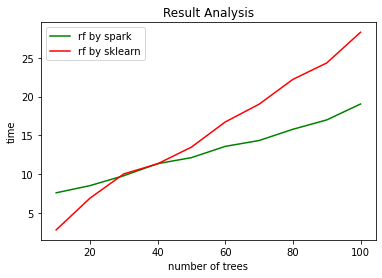

In [27]:
x_axix=range(10,101,10)

plt.title('Result Analysis')
plt.plot(x_axix, time_rf_spark, color='green', label='rf by spark')
plt.plot(x_axix, time_rf_sklearn, color='red', label='rf by sklearn')

plt.legend() 

plt.xlabel('number of trees')
plt.ylabel('time')
plt.show()

In the end we get the scientific result! When the number of trees in the random forest increases, that is, the algorithm becomes more complex, the parallel computing in spark has a smaller increase in time. When the number of trees exceeds a certain threshold, the random forest model based on parallel computing has better computing performance. This shows that parallel computing requires a large amount of calculation to give full play to its advantages!

In [28]:
pickle.dump(time_dt, open( "time_dt.p", "wb" ) )
pickle.dump(time_rf_spark, open( "time_rf_spark.p", "wb" ) )
pickle.dump(time_rf_sklearn, open( "time_rf_sklearn.p", "wb" ) )

## References

[pyspark installation](https://github.com/dsbristol/pyspark)

[Machine Learning with PySpark and MLlib](https://towardsdatascience.com/machine-learning-with-pyspark-and-mllib-solving-a-binary-classification-problem-96396065d2aa)

[Spark RandomForestClassifier](http://spark.apache.org/docs/latest/api/python/reference/api/pyspark.ml.classification.RandomForestClassifier.html)

[PySpark document](https://spark.apache.org/docs/latest/api/python/)

[First Steps With PySpark and Big Data Processing](https://realpython.com/pyspark-intro/)